IMPORTING LIBRARIES

In [5]:
from __future__ import absolute_import,division, print_function, unicode_literals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib
from tensorflow.python.tpu import feature_column_v2 as fc
import tensorflow as tf

READING THE DATA FROM CVS

In [6]:
dftrain = pd.read_csv('datasets/train.csv')
dfeval = pd.read_csv('datasets/eval.csv')
print(dftrain.head())
print("\n",dfeval.head())

   survived     sex   age  n_siblings_spouses  parch     fare  class     deck  \
0         0    male  22.0                   1      0   7.2500  Third  unknown   
1         1  female  38.0                   1      0  71.2833  First        C   
2         1  female  26.0                   0      0   7.9250  Third  unknown   
3         1  female  35.0                   1      0  53.1000  First        C   
4         0    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  

    survived     sex   age  n_siblings_spouses  parch     fare   class  \
0         0    male  35.0                   0      0   8.0500   Third   
1         0    male  54.0                   0      0  51.8625   First   
2         1  female  58.0                   0      0  26.5500   First   
3         1  female  55.0                   0      0  16.0000  Second   
4       

POPPING THE "Survived" COLUMN

In [7]:
y_train=dftrain.pop('survived')
y_eval=dfeval.pop('survived')
print(dftrain.head())
print("\n",dfeval.head())
print("\n",y_train.head())
print("\n",y_eval.head())

      sex   age  n_siblings_spouses  parch     fare  class     deck  \
0    male  22.0                   1      0   7.2500  Third  unknown   
1  female  38.0                   1      0  71.2833  First        C   
2  female  26.0                   0      0   7.9250  Third  unknown   
3  female  35.0                   1      0  53.1000  First        C   
4    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  

       sex   age  n_siblings_spouses  parch     fare   class     deck  \
0    male  35.0                   0      0   8.0500   Third  unknown   
1    male  54.0                   0      0  51.8625   First        E   
2  female  58.0                   0      0  26.5500   First        C   
3  female  55.0                   0      0  16.0000  Second  unknown   
4    male  34.0                   0      0  13.0000  Second        D   



DISPLAY DIFFERENT ASPECT ( Not that imp )

<AxesSubplot: >

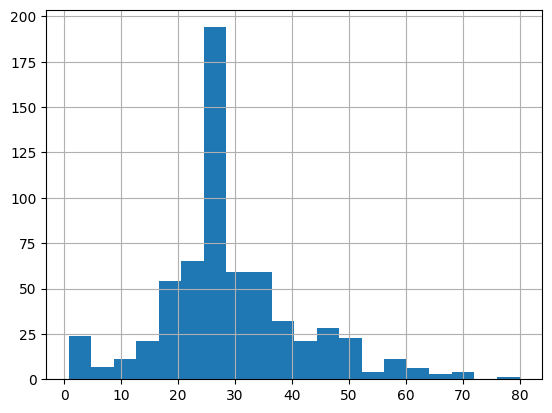

In [9]:
dftrain.age.hist(bins=20)

<AxesSubplot: >

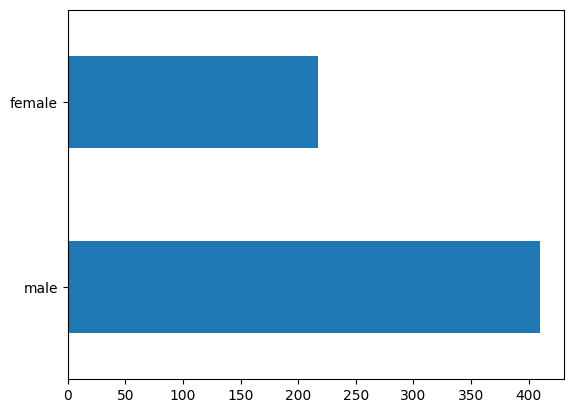

In [10]:
dftrain.sex.value_counts().plot(kind='barh')

<AxesSubplot: ylabel='class'>

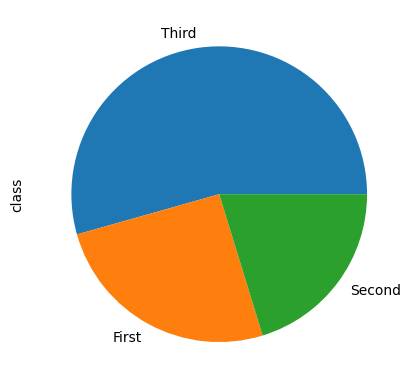

In [11]:
dftrain['class'].value_counts().plot(kind='pie')

Text(0.5, 0, '% survive')

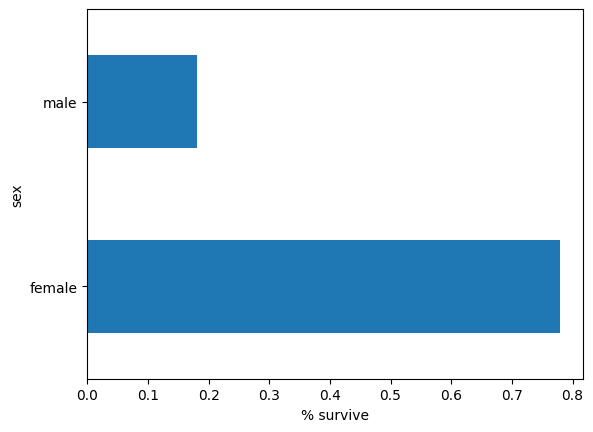

In [12]:
pd.concat([dftrain,y_train],axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

SETTING CATEGORICAL AND NUMERIC COLUMNS

In [13]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck','embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

MAKING THE FEATURE COLUMN ( Column entries will be grouped and for each column it will contain a set of values it can have )

In [15]:
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()  
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))
print(feature_columns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

INPUT FUNCTION TO FEED THE MODEL

In [16]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df)) 
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs) 
    return ds 
  return input_function

FEEDING THE TRAIN DATASET AND EVAL DATASET

In [17]:
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

CALCULATING THE PREDICTION 

In [18]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn) 

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\ADITYA\\AppData\\Local\\Temp\\tmpbw0cyj6q', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use Variable.read_

PRINTING ACCURACY

In [19]:
print(result )
print(result['accuracy'])

{'accuracy': 0.77272725, 'accuracy_baseline': 0.625, 'auc': 0.82886446, 'auc_precision_recall': 0.78962016, 'average_loss': 0.49408, 'label/mean': 0.375, 'loss': 0.48417637, 'precision': 0.73493975, 'prediction/mean': 0.33041838, 'recall': 0.61616164, 'global_step': 200}
0.77272725


ANALYZING ANSWER ( PROBABILITY OF SURVIVAL )

In [20]:
result = list(linear_est.predict(eval_input_fn))
print(dfeval.loc[5])
print(y_eval.loc[5])
print(result[5]['probabilities'][1]*100," %")

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\ADITYA\AppData\Local\Temp\tmpbw0cyj6q\model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
sex                       female
age                         15.0
n_siblings_spouses             0
parch                          0
fare                      8.0292
class                      Third
deck                     unknown
embark_town           Queenstown
alone                          y
Name: 5, dtype: object
1
73.00184369087219  %
